In [1]:
from UTILITY_quickstart import *

importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline.yml")

In [2]:
csrTF = False


bunchCount = importedDefaultSettings["bunchCount"]

tao = initializeTao(
    inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],
    
    csrTF = csrTF,
    numMacroParticles=1e4,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

setLattice(tao, **importedDefaultSettings)
launchTwissCorrection(tao)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_15778095577731598405.h5, and reinit to tao
No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [28.77872199 13.3970811  23.51278494 16.8307956 ]
Objective Function Value at Optimal Parameters: 9.505958617749993e-12
Number of Iterations: 260
Converged: True


In [3]:
#trackStart now upstream of BC14 to remove energy spread
trackStart = "ENDL2F" #"ENDBC14E"
trackEnd = "PR15944"

trackBeam(tao, trackEnd = trackStart, **importedDefaultSettings)
PStart = getBeamAtElement(tao, trackStart)

#Make beam monochromatic
print(np.std(PStart.pz))
meanEnergy = np.mean(PStart.pz)

PStart.pz = [meanEnergy for i in PStart.pz]
print(np.std(PStart.pz))



makeBeamActiveBeamFile( PStart, tao = tao )

60645980.96326136
0.0


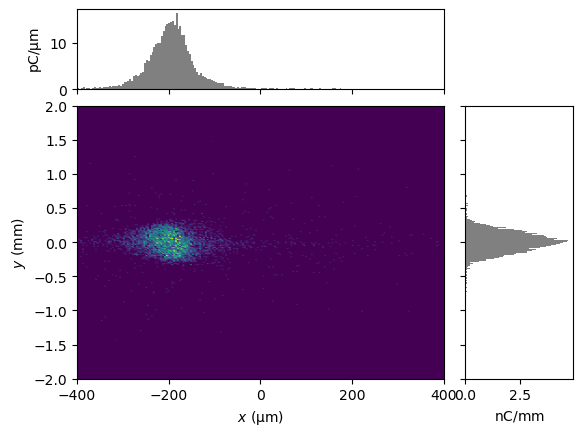

{'PDrive_median_x': -0.0001945399773979771,
 'PDrive_median_y': 1.4326574028199064e-06,
 'PDrive_median_xp': -5.872317412903526e-06,
 'PDrive_median_yp': -1.3840731135978244e-08,
 'PDrive_sigmaSI90_x': 7.324569697992983e-05,
 'PDrive_sigmaSI90_y': 0.00014802968560145155,
 'PDrive_sigmaSI90_z': 0.00046291552676381166,
 'PDrive_sigmaSI90_xp': 1.2568316466453726e-05,
 'PDrive_sigmaSI90_yp': 5.376259133842588e-06,
 'PDrive_emitSI90_x': 5.5047952564332615e-06,
 'PDrive_emitSI90_y': 3.1714420390581776e-06,
 'PDrive_norm_emit_x': 5.109736516042281e-06,
 'PDrive_norm_emit_y': 1.5744146365102046e-06,
 'PDrive_charge_nC': 1.599680000000001}

<Figure size 640x480 with 0 Axes>

In [4]:
trackBeam(tao, trackStart = trackStart, trackEnd = trackEnd, **importedDefaultSettings)

P = getBeamAtElement(tao, trackEnd)
display(plotMod(P, 'x', 'y', bins=300, xlim = (-0.4e-3, 0.4e-3), ylim = (-2e-3,2e-3)))
plt.clf()

getBeamSpecs(P)



In [5]:
data = []
quadStep = 2
allQuadSettings = np.arange(-60, 0 + quadStep, quadStep)

for quadSetting in allQuadSettings:
    setQuadkG(tao, "Q14901", quadSetting)


    transferMatrix = getMatrix(tao, trackStart, trackEnd)

    trackBeam(tao, trackStart = trackStart, trackEnd = trackEnd, **importedDefaultSettings)

    P = getBeamAtElement(tao, trackEnd)
    
    spotSize = smallestIntervalImpliedSigma(P.x)
    #spotSize = P["sigma_x"]

    data.append(
        {
            "quadSetting" : quadSetting,
            "R11" : transferMatrix[0][0],
            "R12" : transferMatrix[0][1],
            "sigma" : spotSize,
            "beam" : P
        }
    )

In [6]:
generalizedEmittanceSolver( data, energyGeV = 4.5 )

{'beta': 0.8778045266942949,
 'alpha': 0.43207800480642067,
 'emitGeo': 1.0320896498978817e-11,
 'emit': 9.088852102818919e-08}

In [7]:
PStart.twiss()#(fraction = 0.95)

{'alpha_x': -0.6206496218123703,
 'beta_x': 73.72428957445342,
 'gamma_x': 0.018789003746952793,
 'emit_x': 1.408571569726913e-09,
 'eta_x': 138486.67008303924,
 'etap_x': 7300.604608488504,
 'norm_emit_x': 1.2217768777953498e-05}

In [8]:
smallestIntervalImpliedEmittance(PStart)

7.817697110521472e-06

In [9]:
PStart.twiss(fraction = 0.9)

{'alpha_x': -0.5686558981435055,
 'beta_x': 67.9833696742005,
 'gamma_x': 0.01946607731913606,
 'emit_x': 6.360948660167911e-10,
 'eta_x': 536133.7677155584,
 'etap_x': 3277.7682935366324,
 'norm_emit_x': 5.517405122132891e-06}

## Comparing different methods of spot size calculation

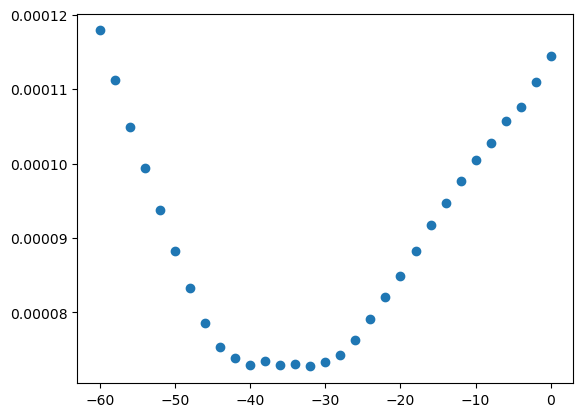

In [10]:
plt.clf() 
plt.scatter(
    [i["quadSetting"] for i in data],
    [smallestIntervalImpliedSigma(i["beam"]["x"]) for i in data]
)
    

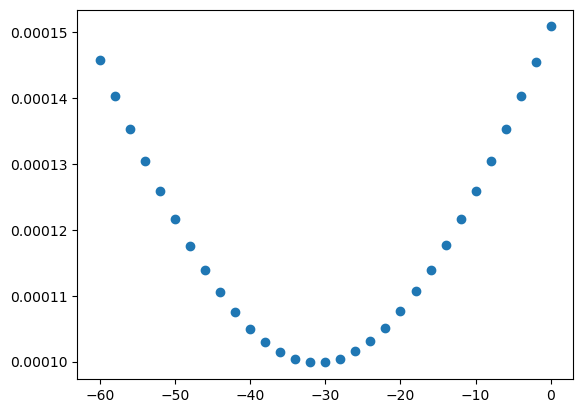

In [11]:
plt.clf() 
plt.scatter(
    [i["quadSetting"] for i in data],
    [(i["beam"])["sigma_x"] for i in data]
)

In [12]:
def spotFromTwiss(P, fraction = 1):
    twiss = P.twiss(fraction = fraction)
    return np.sqrt(  twiss['beta_x'] * twiss['emit_x'] )

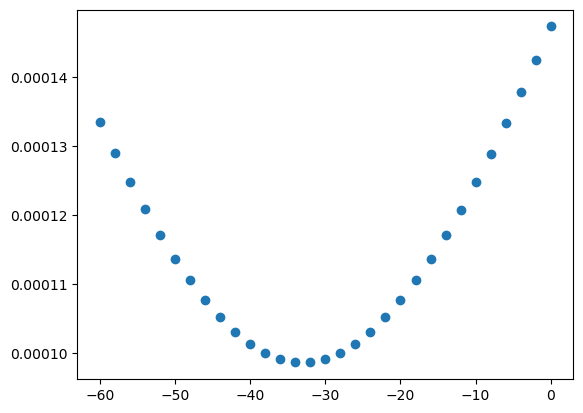

In [13]:
plt.clf() 
plt.scatter(
    [i["quadSetting"] for i in data],
    [spotFromTwiss(i["beam"]) for i in data]
)

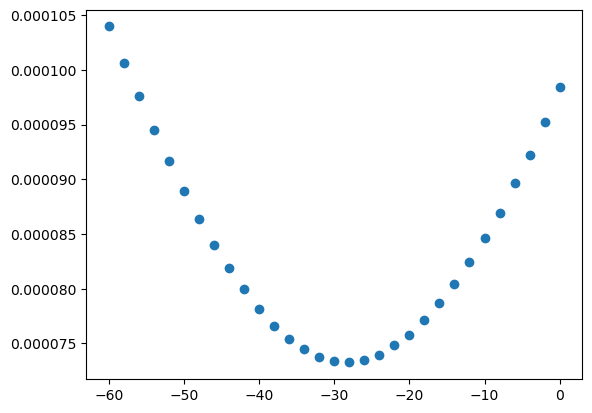

In [14]:
plt.clf() 
plt.scatter(
    [i["quadSetting"] for i in data],
    [spotFromTwiss(i["beam"], fraction = 0.95) for i in data]
)

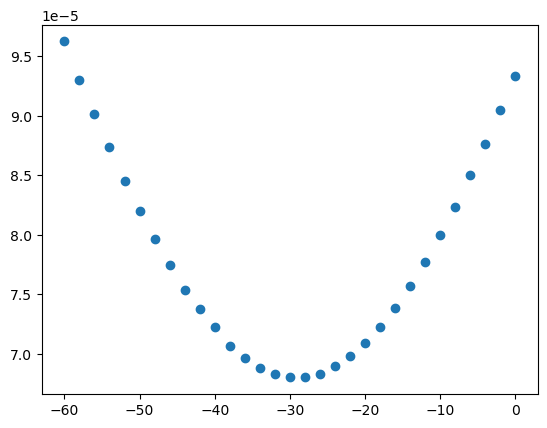

In [15]:
plt.clf() 
plt.scatter(
    [i["quadSetting"] for i in data],
    [spotFromTwiss(i["beam"], fraction = 0.90) for i in data]
)

## Emittance results

In [16]:
dataTmp = data.copy()

for row in dataTmp:
    row["sigma"] = smallestIntervalImpliedSigma(row["beam"]["x"])

generalizedEmittanceSolver( dataTmp, energyGeV = 4.5 )

{'beta': 0.8778045266942949,
 'alpha': 0.43207800480642067,
 'emitGeo': 1.0320896498978817e-11,
 'emit': 9.088852102818919e-08}

In [17]:
smallestIntervalImpliedEmittance( PStart ) 

7.817697110521472e-06

In [18]:
dataTmp = data.copy()

for row in dataTmp:
    row["sigma"] = spotFromTwiss(row["beam"], fraction = 1.0)

generalizedEmittanceSolver( dataTmp, energyGeV = 4.5 )

{'beta': 0.8731980329341652,
 'alpha': 0.42480189814497415,
 'emitGeo': 1.5906566498888568e-11,
 'emit': 1.4007739578277604e-07}

In [19]:
PStart.twiss(fraction = 1.0)

{'alpha_x': -0.6206496218123703,
 'beta_x': 73.72428957445342,
 'gamma_x': 0.018789003746952793,
 'emit_x': 1.408571569726913e-09,
 'eta_x': 138486.67008303924,
 'etap_x': 7300.604608488504,
 'norm_emit_x': 1.2217768777953498e-05}

In [20]:
dataTmp = data.copy()

for row in dataTmp:
    row["sigma"] = spotFromTwiss(row["beam"], fraction = 0.95)

generalizedEmittanceSolver( dataTmp, energyGeV = 4.5 )

{'beta': 0.8776096836909539,
 'alpha': 0.43226846873373265,
 'emitGeo': 9.491792531433847e-12,
 'emit': 8.35872140732922e-08}

In [21]:
PStart.twiss(fraction = 0.95)

{'alpha_x': -0.49617160038260705,
 'beta_x': 65.71671055513144,
 'gamma_x': 0.01896300418111737,
 'emit_x': 7.439329141284084e-10,
 'eta_x': 424999.3906044859,
 'etap_x': 4036.2731344799035,
 'norm_emit_x': 6.452778493016236e-06}

In [22]:
dataTmp = data.copy()

for row in dataTmp:
    row["sigma"] = spotFromTwiss(row["beam"], fraction = 0.9)

generalizedEmittanceSolver( dataTmp, energyGeV = 4.5 )

{'beta': 0.8706050701692147,
 'alpha': 0.4230245562441278,
 'emitGeo': 8.115378085152474e-12,
 'emit': 7.14661475209122e-08}

In [23]:
PStart.twiss(fraction = 0.9)

{'alpha_x': -0.5686558981435055,
 'beta_x': 67.9833696742005,
 'gamma_x': 0.01946607731913606,
 'emit_x': 6.360948660167911e-10,
 'eta_x': 536133.7677155584,
 'etap_x': 3277.7682935366324,
 'norm_emit_x': 5.517405122132891e-06}

## Gaussian fit the data to get the sigmas

This is the closest to how we do it on the machine

In [24]:
#Blob of code from ChatGPT

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + offset

def fit_gaussian_to_binned_data(data, bin_size, plot=False):
    # Bin the data
    min_val, max_val = min(data), max(data)
    bins = np.arange(min_val, max_val + bin_size, bin_size)
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Initial guesses for the fit
    A_guess = max(hist)
    mu_guess = np.mean(data)
    sigma_guess = np.std(data)
    offset_guess = min(hist)
    p0 = [A_guess, mu_guess, sigma_guess, offset_guess]
    
    # Fit the Gaussian
    try:
        popt, _ = curve_fit(gaussian, bin_centers, hist, p0=p0)
    except RuntimeError:
        raise RuntimeError("Gaussian fit failed")
    
    # Extract fitted parameters
    _, _, sigma_fitted, _ = popt
    
    if plot:
        plt.bar(bin_centers, hist, width=bin_size * 0.9, alpha=0.6, label='Binned Data')
        x_fit = np.linspace(min_val, max_val, 500)
        y_fit = gaussian(x_fit, *popt)
        plt.plot(x_fit, y_fit, 'r-', label='Gaussian Fit')
        plt.legend()
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.show()
    
    return sigma_fitted

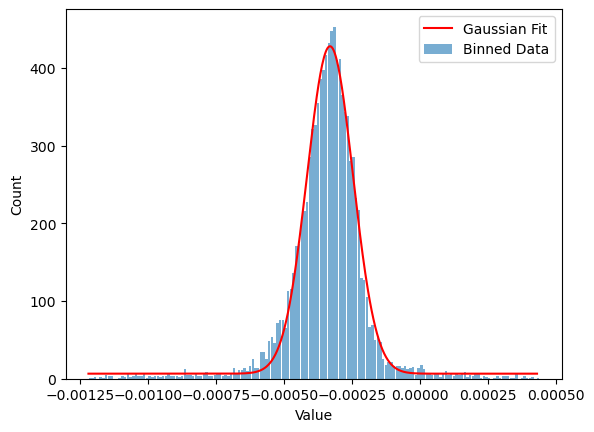

8.443842053853831e-05

In [25]:
fit_gaussian_to_binned_data( data[0]["beam"]["x"], 10e-6, plot = True )

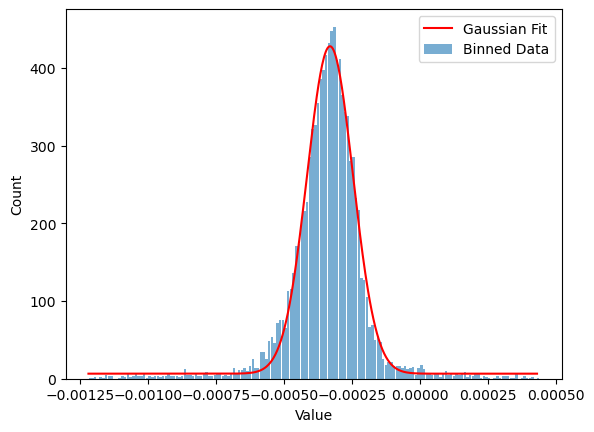

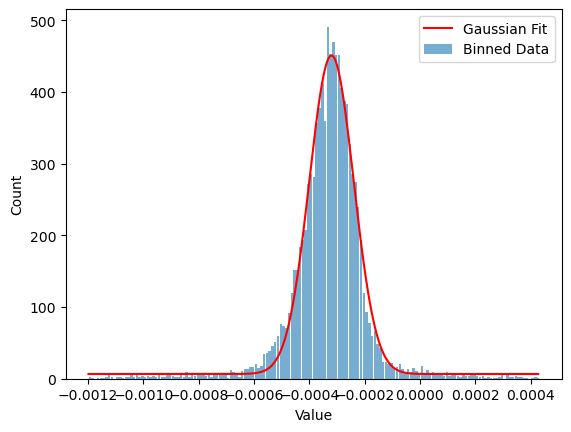

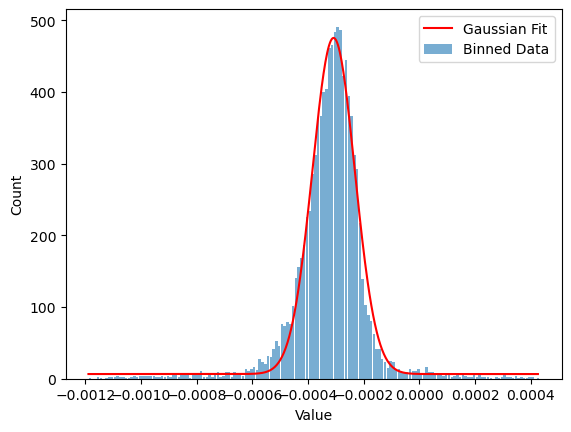

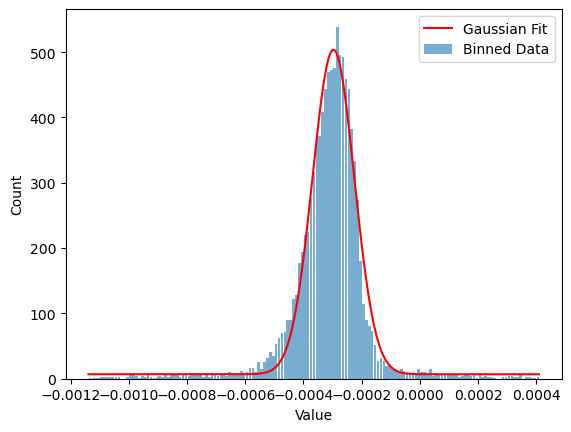

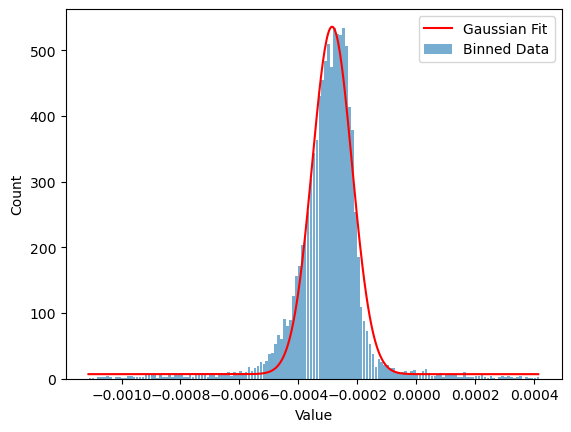

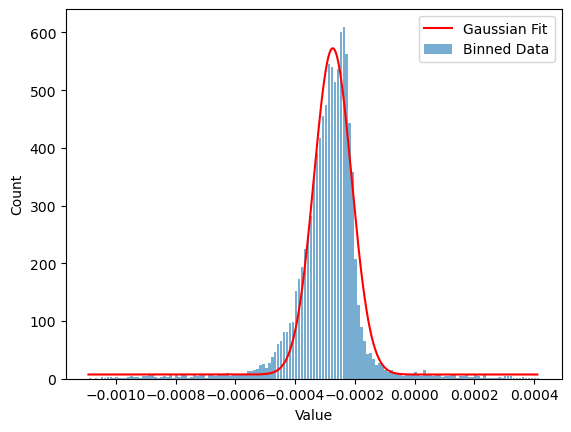

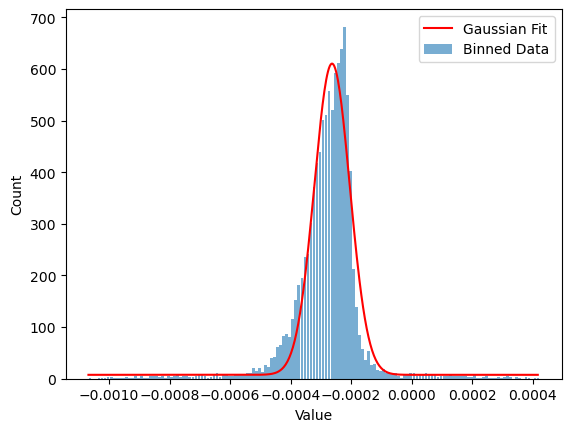

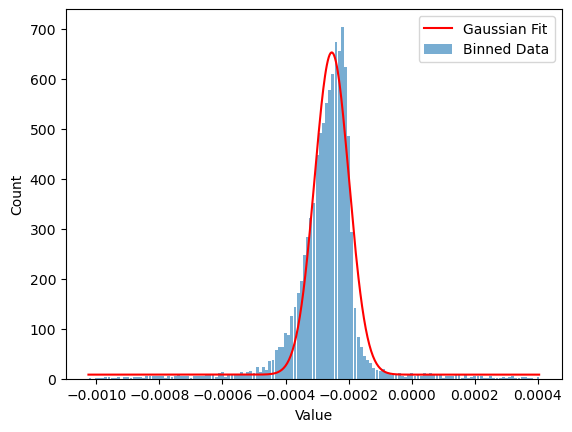

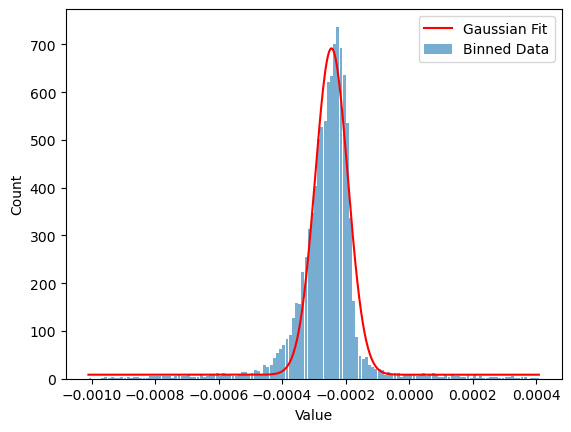

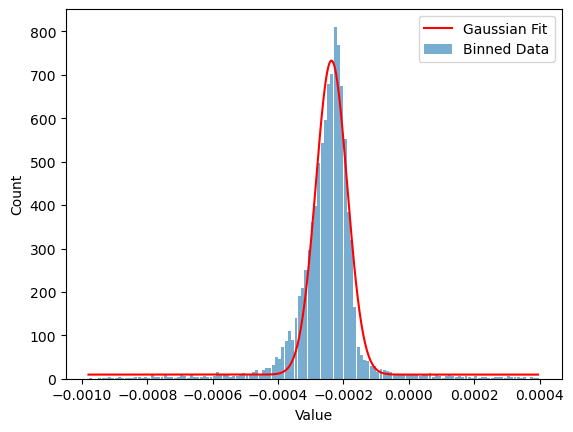

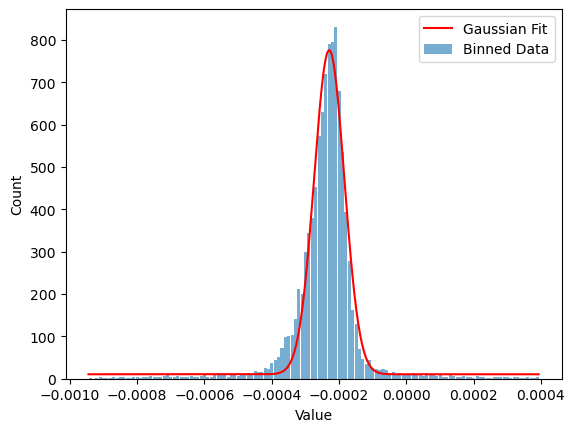

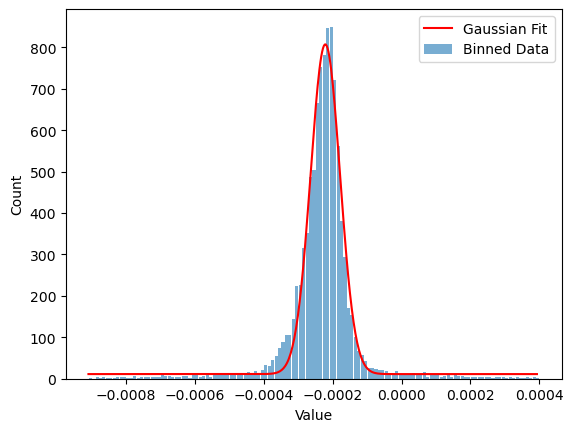

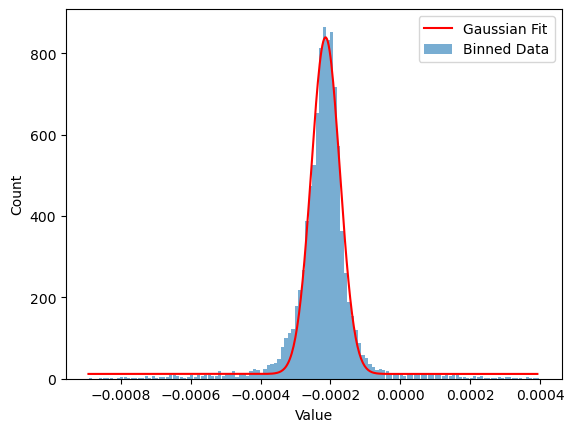

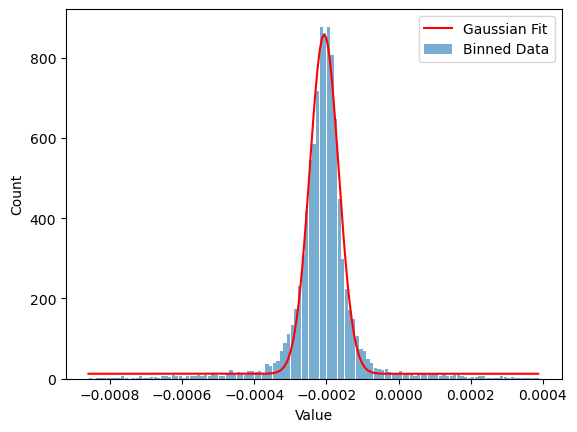

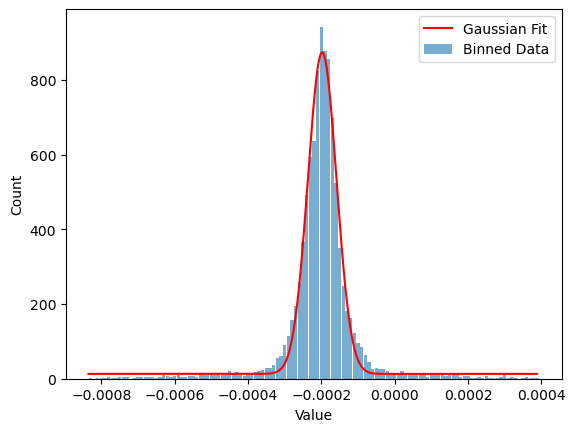

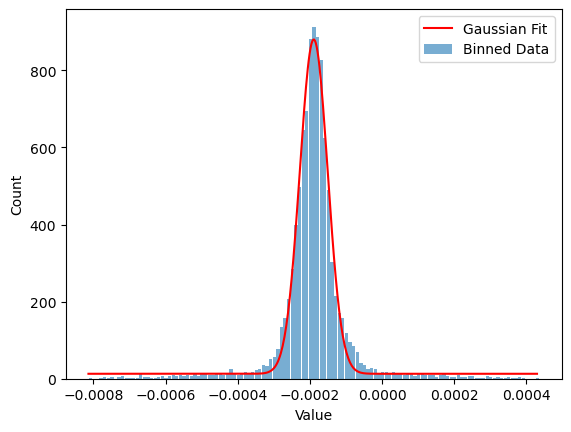

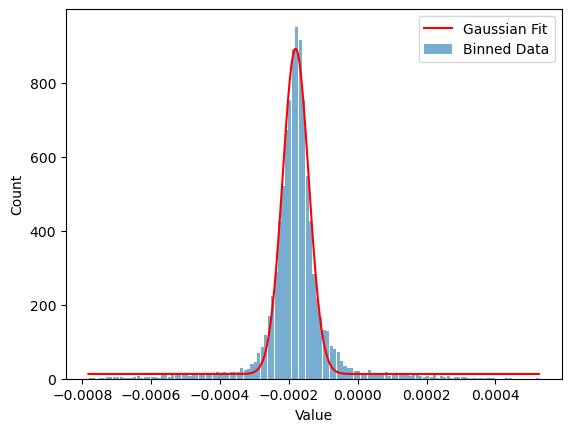

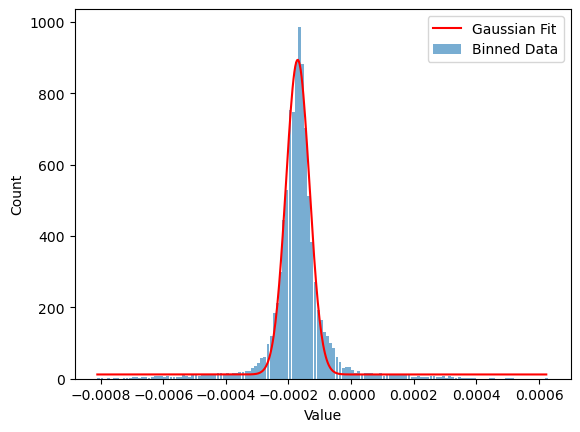

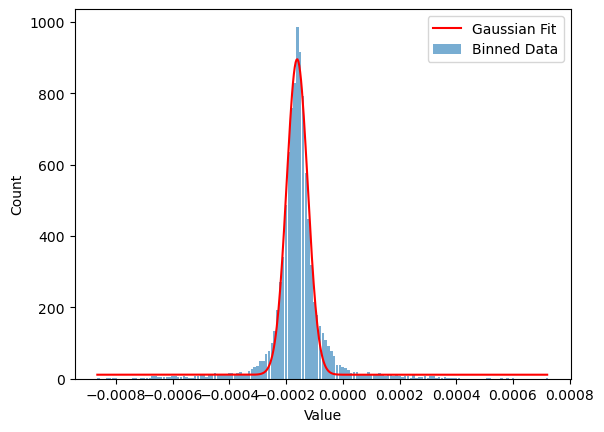

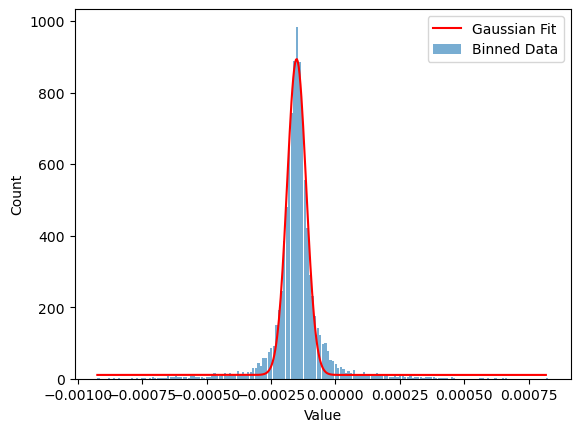

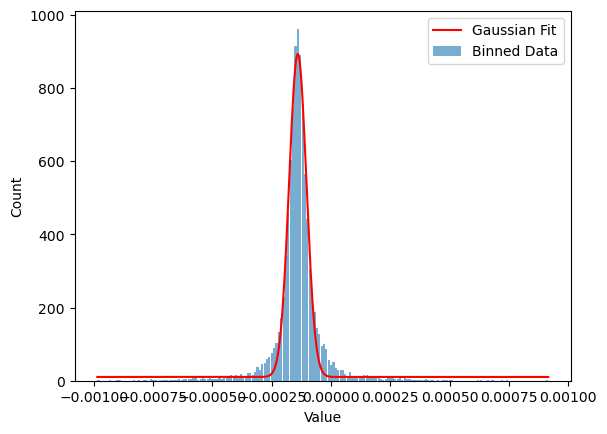

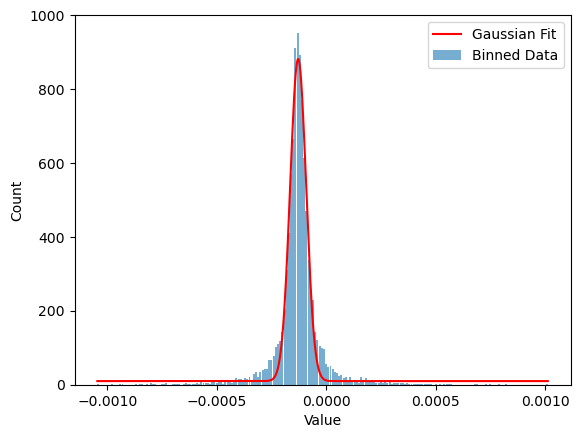

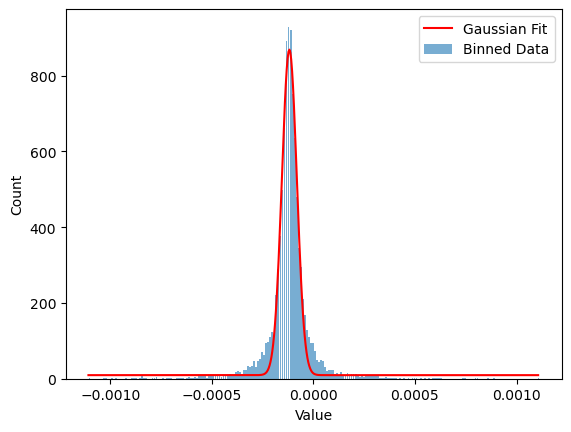

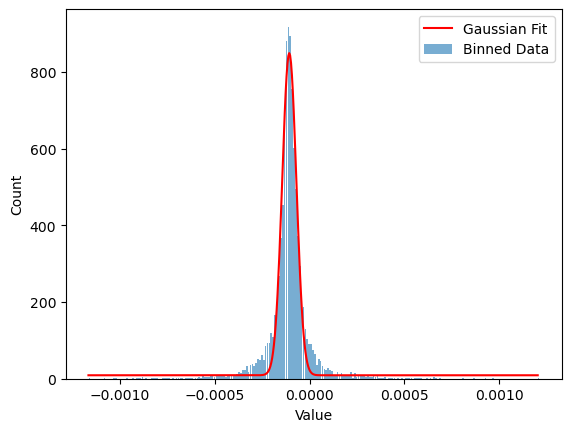

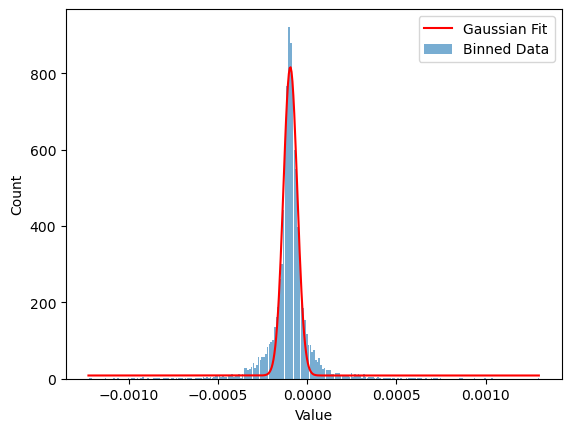

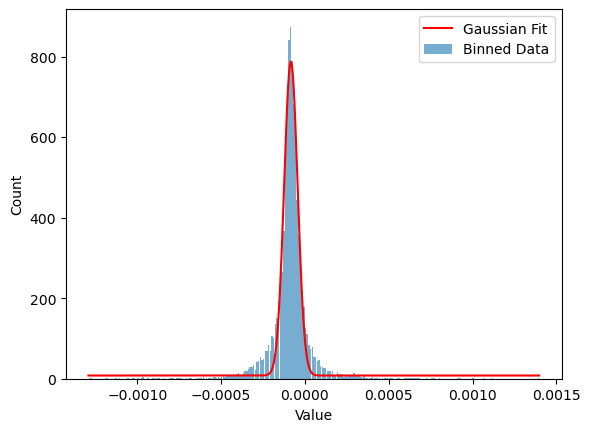

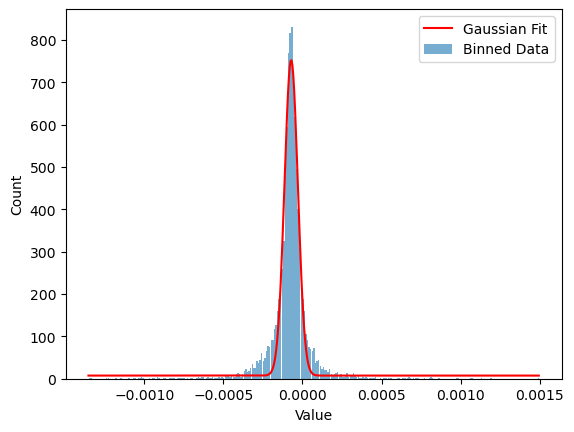

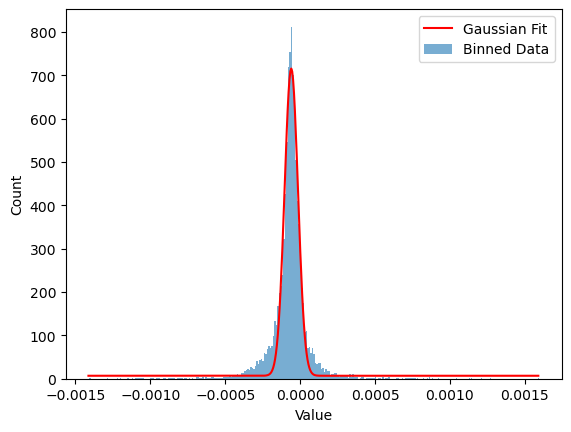

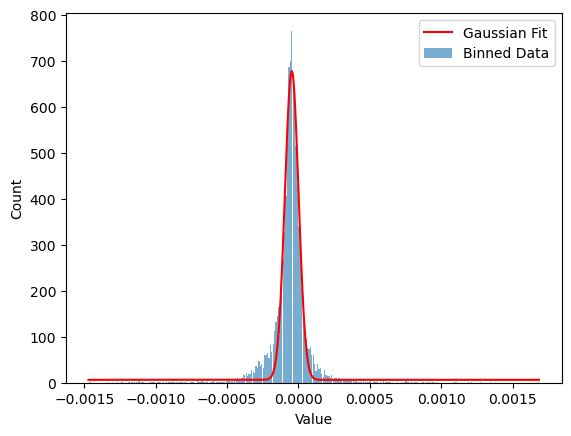

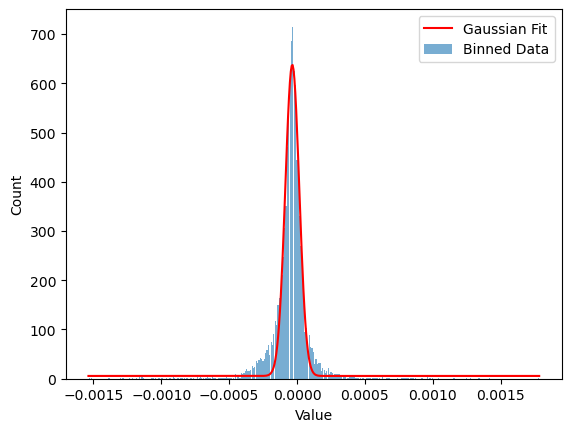

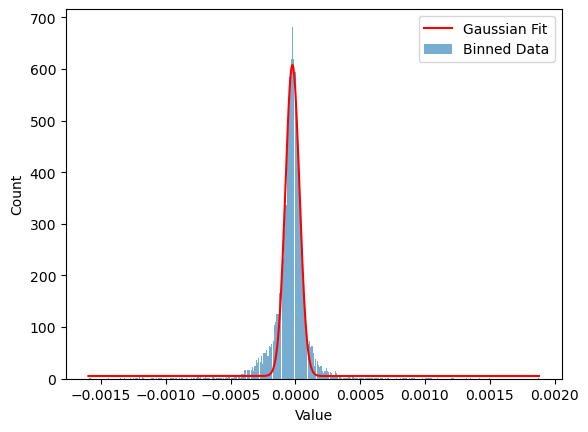

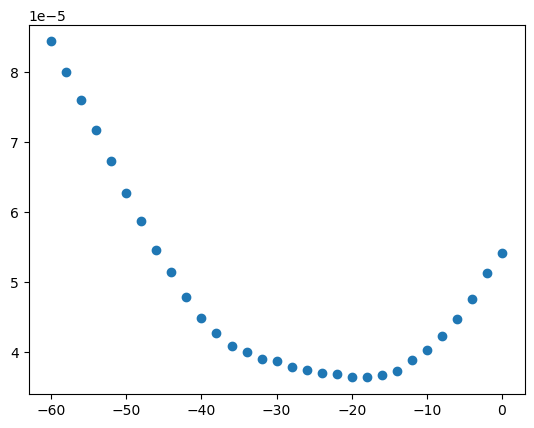

In [26]:
plt.clf() 
plt.scatter(
    [i["quadSetting"] for i in data],
    [fit_gaussian_to_binned_data( i["beam"]["x"], 10e-6, plot = True ) for i in data]
)

Like the smallestInterval version, also very much not a parabola

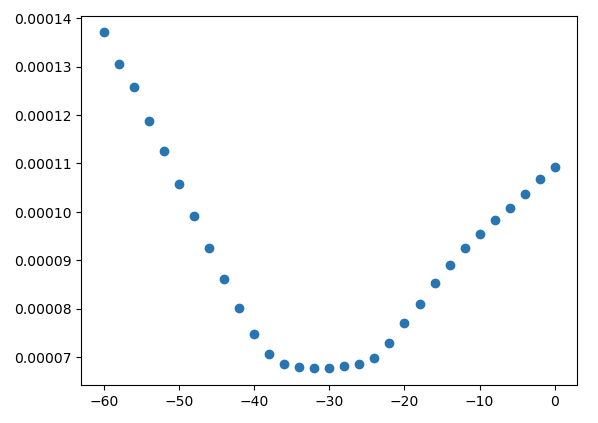